In [1]:
import sqlite3

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
con = sqlite3.connect('final.sqlite') # this is cleaned dataset
final = pd.read_sql_query("""
SELECT Text_not_included
FROM reviews
""", con)[:4000]

In [3]:
for i, seq in enumerate(final['Text_not_included']):
  final['Text_not_included'][i]=final['Text_not_included'][i].decode('UTF-8')

## Generate Average word2vec

In [4]:
sentences=[]
for review in final['Text_not_included']:
  sentence=[]
  for word in review.split():
    sentence.append(word)
  sentences.append(sentence)

w2vec_model=gensim.models.word2vec.Word2Vec(sentences, min_count=5)

avg_w2vec=np.zeros(shape=(len(final['Text_not_included']), 100), dtype=float)

for i, sentence in enumerate(sentences):
  for word in sentence:
    try:
      avg_w2vec[i]+=w2vec_model.wv[word]
    
    except KeyError:
      pass
  
  avg_w2vec[i]/=len(sentence)

## Generate count BoW

In [38]:
count_vect = CountVectorizer(ngram_range=(1,2) )
count_vect.fit(final['Text_not_included'])
bow = count_vect.transform(final['Text_not_included'])

## Standardisation

In [5]:
scaler_avg_w2vec=StandardScaler()

avg_w2vec_scaled=scaler_avg_w2vec.fit_transform(avg_w2vec)

In [39]:
scaler_bow=StandardScaler(with_mean=False)
bow_scaled=scaler_bow.fit_transform(bow)

/home/vishal/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## KMeans clustering with TF IDF word2vec

In [6]:
k_list=list(range(1,400,1))
loss_list=[]

In [7]:
# determine the best k
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(avg_w2vec_scaled)
    loss=0
    
    for i, point in enumerate(avg_w2vec_scaled):
        cluster=kmeans.labels_[i]
        center=kmeans.cluster_centers_[cluster]
        loss+=np.linalg.norm(point-center)
        
    loss_list.append(loss)

399

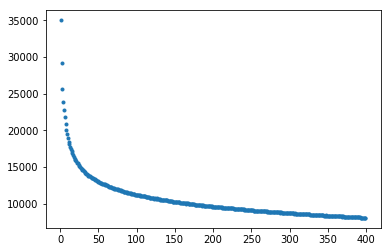

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_list, loss_list, '.')
k_list[np.argmin(loss_list)]

Decrease in loss is not much appreciable after k=50

In [9]:
kmeans = KMeans(n_clusters=50, random_state=0).fit(avg_w2vec_scaled)

In [34]:
english = pd.read_sql_query("""
SELECT Text
FROM reviews
""", con)[:4000]

In [36]:
for i in range(50):
    print("Cluster #{}\n".format(i))
    reviews_in_this_cluster = english['Text'][np.where(kmeans.labels_==i)[0]]
    for review in reviews_in_this_cluster[:10]:
        print(review + "\n")

Cluster #0

My daughter loved the little tin that came with her Adagio tea set so much that I got her a cannister of this for Christmas.  I think it will end up being a regular gift as we all love it so much.  It really is delicious, and with green tea being so good for you, we drink it all the time.  All the products I've tried from Adagio have been wonderful.

I normally hate, hate, hate citrus anything in my tea.  I always thought it tasted the way lemon dish soap smells.  I received this tea in a sampler and wow, I can't get enough of it.  It's the first citrus flavored tea I've ever liked in my life.  It smells really good, sorta like Froot Loops, and I didn't even need to put any sugar or honey in it to enjoy it.

These arrived nice and fresh. They are a tad more tart than expected but I like them.

We are big fans of the Passion Fruit Tea but wanted to try something different. I like all of the flavors but the blackberry is my fave for a change of pace, still got to have the pas

## Clusters identified
Cluster 0 is related to tea<br>
Cluster 2 related to chinese food and sauces<br>
Cluster 10 related to hot chocolate and coffee<br>
Cluster 33 has health foods - pretzels, beans, healthy chips

## KMeans clustering with BoW

In [37]:
k_list=list(range(1,400,1))
loss_list=[]

In [ ]:
# determine the best k
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(bow_scaled)
    loss=0
    
    for i, point in enumerate(bow_scaled):
        cluster=kmeans.labels_[i]
        center=kmeans.cluster_centers_[cluster]
        loss+=np.linalg.norm(point-center)
        
    loss_list.append(loss)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_list, loss_list, '.')